# Add public Vector Dataset

In [1]:
import geoengine as ge
from datetime import datetime

Initialize Geo Engine as Admin

In [2]:
ge.initialize("http://localhost:3030/api", admin_token="8aca8875-425a-4ef1-8ee6-cdfc62dd7525")

List volumes

In [3]:
volumes = ge.volumes()
volumes

[Volume(name='test_data', path='test_data/')]

 Define metadata

In [4]:
file_path = "vector/data/germany_polygon.gpkg" # specify file path relative to volume path

layer_name = "test_germany" # specify layer name

ogr_params = ge.api.OgrLoadingInfo(
  fileName = file_path,
  layerName = layer_name,
  dataType = "MultiPolygon",
  time = ge.api.OgrSourceDatasetTimeType(type='none'),
  columns = ge.api.OgrLoadingInfoColumns(
    x = "",
    y = "",
    float = [],
    int = [],
    text = [],
  ),
  onError = ge.api.OgrOnError.ABORT,
)

result_descriptor = ge.VectorResultDescriptor(
    spatial_reference="EPSG:4326", 
    data_type=ge.VectorDataType.MULTI_POLYGON, 
    columns={},
    spatial_bounds = ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
    time_bounds = None,
)

meta_data = ge.api.OgrMetadata(
  type = "OgrMetaData",
  loadingInfo = ogr_params,
  resultDescriptor = result_descriptor.to_api_dict(),
)    

meta_data

{'type': 'OgrMetaData',
 'loadingInfo': {'fileName': 'vector/data/germany_polygon.gpkg',
  'layerName': 'test_germany',
  'dataType': 'MultiPolygon',
  'time': {'type': 'none'},
  'columns': {'x': '', 'y': '', 'float': [], 'int': [], 'text': []},
  'onError': <OgrOnError.ABORT: 'abort'>},
 'resultDescriptor': {'type': 'raster',
  'dataType': <VectorDataType.MULTI_POLYGON: 'MultiPolygon'>,
  'spatialReference': 'EPSG:4326',
  'columns': {},
  'time': None,
  'bbox': {'lowerLeftCoordinate': {'x': 5.85249, 'y': 47.271121},
   'upperRightCoordinate': {'x': 15.022059, 'y': 55.065334}},
  'resolution': None}}

In [5]:
add_dataset_properties = ge.DatasetProperties( 
    name = "Germany Polygon",
    source_operator = "OgrSource",
    description = "Germany polygon for testing purposes",
    symbology = None, 
    provenance=[ge.Provenance(
      citation="Geo Engine et.al (2023)",
      uri="TODO",
      license="TODO",
    )],


)

add_dataset_properties.to_api_dict()

{'id': None,
 'name': 'Germany Polygon',
 'description': 'Germany polygon for testing purposes',
 'sourceOperator': 'OgrSource',
 'symbology': None,
 'provenance': [{'citation': 'Geo Engine et.al (2023)',
   'license': 'TODO',
   'uri': 'TODO'}]}

Add dataset to the matching volume

In [6]:
volume = [v for v in volumes if v.name == "test_data"][0] # this is the "test_data" volume

dataset_id = ge.add_dataset(volume, add_dataset_properties, meta_data)

dataset_id

2e1dc6da-3bb3-4285-96c0-2d970e22c477

Verify that data is accessible for user

In [7]:
def create_ogr_source_workflow(dataset_id): 
    return {
        "type": "Vector",
        "operator": {
            "type": "OgrSource",
            "params": {
                "data": {
                    "type": "internal",
                    "datasetId": str(dataset_id)
                },
            }
        }
    }

workflow = ge.register_workflow(create_ogr_source_workflow(dataset_id))

workflow.get_result_descriptor()

Data type:         MultiPolygon
Spatial Reference: EPSG:4326
Columns:

Load the data

<Axes: >

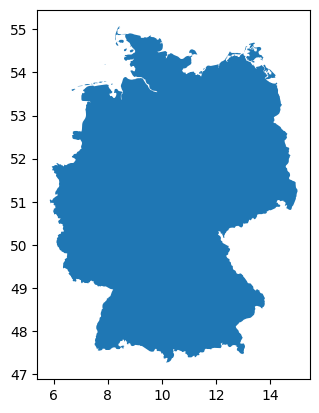

In [8]:
time = datetime.strptime(
    '2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

data = workflow.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(1. , 1.),
        srs="EPSG:4326"
        )
)

data.plot()

Delete the dataset

In [9]:
ge.reset()
ge.initialize("http://localhost:3030/api", admin_token="8aca8875-425a-4ef1-8ee6-cdfc62dd7525")

ge.delete_dataset(dataset_id)

Verify the dataset was deleted

In [10]:
try:
    data = workflow.get_dataframe(
        ge.QueryRectangle(
            ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
            ge.TimeInterval(time, time),
            resolution=ge.SpatialResolution(1. , 1.),
            srs="EPSG:4326"
            )
    )
except Exception as e:
    print(e)

Operator: Operator: LoadingInfoError: Operator: DatasetMetaData: UnknownDatasetId
